#  Exploratory Data Analysis (EDA)

## Comprehensive Dataset Audit & Visualization

This notebook provides a complete data exploration covering:
- **Dataset Inventory**: All datasets and their structure
- **Split Analysis**: Train/Val/Test distribution and balance
- **Data Quality**: Corruption detection, missing files, resolution analysis
- **Data Integrity**: Duplicate detection (perceptual + exact) and data leaks
- **Visual Analysis**: Sample images, color distributions, augmentations
- **Embeddings**: t-SNE visualization of ResNet-50 features
- **Statistics**: Normalization parameters and summary report

In [21]:
# =====================================================
# IMPORTS & CONFIGURATION
# =====================================================
from pathlib import Path
import os, math, json, random, hashlib
import numpy as np, pandas as pd
from PIL import Image, ImageOps, ImageEnhance
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import torchvision.transforms as T
from torchvision.models import resnet50, ResNet50_Weights
import warnings
warnings.filterwarnings('ignore')

# Visualization config
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✅ Setup complete")
print(f"🖥️  Device: {DEVICE}")

✅ Setup complete
🖥️  Device: cpu


In [ ]:
# =====================================================
# PATHS & DIRECTORIES
# =====================================================
# Get the parent directory (project root)
BASE = Path.cwd().parent
DATA = BASE / 'dataset'

# Dataset paths
EXTERNAL = DATA / 'external'
PROCESSED = DATA / 'processed'
MERGED = DATA / 'merged'
BALANCED = DATA / 'balanced'
SPLITS = DATA / 'splits'

# Output directory
OUT = BASE / 'notebooks' / 'eda_outputs'
OUT.mkdir(parents=True, exist_ok=True)

print(f"📂 Project Root: {BASE}")
print(f"📊 Dataset: {DATA}")
print(f"📁 Outputs: {OUT}")
print(f"\n✅ Path verification:")
print(f"   Dataset exists: {DATA.exists()}")
print(f"   Splits exists: {SPLITS.exists()}")

📂 Project Root: c:\Users\zaineb\Desktop\spices 2-2
📊 Dataset: c:\Users\zaineb\Desktop\spices 2-2\dataset
📁 Outputs: c:\Users\zaineb\Desktop\spices 2-2\notebooks\eda_outputs

✅ Path verification:
   Dataset exists: True
   Splits exists: True


In [23]:
# =====================================================
# HELPER FUNCTIONS
# =====================================================
IMG_EXT = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}

def iter_images(root: Path) -> list:
    """Recursively find all image files in directory."""
    if not root.exists():
        return []
    return sorted([p for p in root.rglob('*') if p.suffix.lower() in IMG_EXT])

def open_image(path: Path) -> Image.Image:
    """Safely open and convert image to RGB."""
    with Image.open(path) as im:
        return im.convert('RGB')

def img_stats(path: Path) -> dict:
    """Extract image statistics: dimensions, brightness, contrast, aspect ratio."""
    try:
        im = open_image(path)
        w, h = im.size
        gray = ImageOps.grayscale(im)
        arr = np.asarray(gray, dtype=np.float32)
        
        return {
            'width': w,
            'height': h,
            'aspect_ratio': round(w/h, 2) if h > 0 else 0,
            'brightness': float(arr.mean()),
            'contrast': float(arr.std()),
            'ok': True
        }
    except Exception as e:
        return {
            'width': None,
            'height': None,
            'aspect_ratio': None,
            'brightness': None,
            'contrast': None,
            'ok': False,
            'error': str(e)
        }

def dhash(im: Image.Image, hash_size=8) -> int:
    """Compute perceptual hash using difference hash algorithm."""
    im_resized = im.resize((hash_size+1, hash_size), Image.LANCZOS).convert('L')
    arr = np.asarray(im_resized)
    diff = arr[:, 1:] > arr[:, :-1]
    return sum(1<<i for (i, v) in enumerate(diff.flatten()) if v)

def hamming(a: int, b: int) -> int:
    """Calculate hamming distance between two hashes."""
    return (a ^ b).bit_count()

def sha1_file(path: Path, chunk_size=1<<20) -> str:
    """Compute SHA1 hash of file for exact duplicate detection."""
    h = hashlib.sha1()
    try:
        with open(path, 'rb') as f:
            while True:
                chunk = f.read(chunk_size)
                if not chunk:
                    break
                h.update(chunk)
        return h.hexdigest()
    except:
        return None

def get_avg_color(path: Path) -> tuple:
    """Get average RGB color of image."""
    try:
        im = open_image(path)
        return tuple(np.asarray(im).mean(axis=(0, 1)))
    except:
        return (None, None, None)

---
## 1. DATASET INVENTORY
Overview of all datasets and their structure


📦 DATASET INVENTORY

🔍 Checking dataset paths:
  external        → c:\Users\zaineb\Desktop\spices 2-2\dataset\external
                     Exists: True
                     Subdirs: 3 found
                     Classes: curcuma, gingembre, poivre noir
  processed       → c:\Users\zaineb\Desktop\spices 2-2\dataset\processed
                     Exists: True
                     Subdirs: 6 found
                     Classes: anis, carvi, cubebe, curcuma, gingembre...
  merged          → c:\Users\zaineb\Desktop\spices 2-2\dataset\merged
                     Exists: True
                     Subdirs: 11 found
                     Classes: anis, cannelle, carvi, clou_girofle, cubebe...
  balanced        → c:\Users\zaineb\Desktop\spices 2-2\dataset\balanced
                     Exists: True
                     Subdirs: 11 found
                     Classes: anis, cannelle, carvi, clou_girofle, cubebe...

📊 Building inventory...



📊 Images per Dataset:


Total Images
external           3000
processed          1457
merged             5457
balanced           2200


📋 Images per Class and Dataset:


external  processed  merged  balanced
curcuma           1000       1087      87       200
gingembre         1000         72      72       200
poivre noir       1000         36      36       200
anis                 0        147     147       200
carvi                0         42      42       200
cubebe               0         73      73       200
cannelle             0          0    1000       200
clou_girofle         0          0    1000       200
cumin                0          0    1000       200
paprika              0          0    1000       200
safran               0          0    1000       200

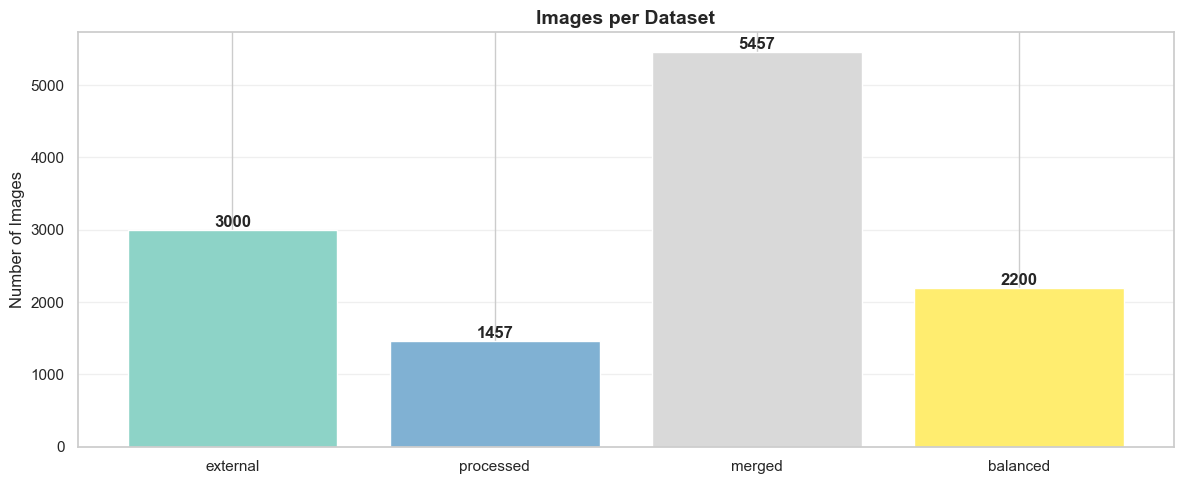

In [24]:
print("\n" + "="*80)
print("📦 DATASET INVENTORY")
print("="*80)

datasets = {'external': EXTERNAL, 'processed': PROCESSED, 'merged': MERGED, 'balanced': BALANCED}
inventory = {}

# First, check which datasets exist and list their contents
print("\n🔍 Checking dataset paths:")
for name, root in datasets.items():
    exists = root.exists()
    print(f"  {name:15} → {root}")
    print(f"  {'':15}    Exists: {exists}")
    
    if exists:
        try:
            # List direct subdirectories (classes)
            subdirs = [d for d in root.iterdir() if d.is_dir()]
            print(f"  {'':15}    Subdirs: {len(subdirs)} found")
            if subdirs:
                print(f"  {'':15}    Classes: {', '.join([d.name for d in subdirs[:5]])}{'...' if len(subdirs) > 5 else ''}")
        except Exception as e:
            print(f"  {'':15}    Error: {e}")

print("\n📊 Building inventory...")
for name, root in datasets.items():
    if root.exists():
        classes = sorted([d.name for d in root.iterdir() if d.is_dir()])
        counts = {}
        
        for c in classes:
            class_dir = root / c
            if class_dir.is_dir():
                # Get all image files recursively in this class directory
                img_files = iter_images(class_dir)
                counts[c] = len(img_files)
                
                if len(img_files) == 0 and c in ['anis', 'curcuma', 'gingembre']:  # Check sample classes
                    # Debug: list what's in the directory
                    contents = list(class_dir.iterdir())
                    print(f"  Debug {name}/{c}: {len(contents)} items - {[item.name for item in contents[:3]]}...")
        
        inventory[name] = {
            'root': str(root),
            'classes': classes,
            'counts': counts,
            'total': sum(counts.values())
        }
    else:
        inventory[name] = {'root': str(root), 'classes': [], 'counts': {}, 'total': 0}

# Summary table
print("\n📊 Images per Dataset:")
summary_df = pd.DataFrame({k: v['total'] for k, v in inventory.items()}, index=['Total Images']).T
display(summary_df)

# Detailed counts
print("\n📋 Images per Class and Dataset:")
detailed_df = pd.DataFrame({k: v['counts'] for k, v in inventory.items() if v['counts']})
display(detailed_df.fillna(0).astype(int))

# Visualization
fig, ax = plt.subplots(figsize=(12, 5))
totals = {k: v['total'] for k, v in inventory.items()}
bars = ax.bar(list(totals.keys()), list(totals.values()), color=plt.cm.Set3(np.linspace(0, 1, len(totals))))
ax.set_title('Images per Dataset', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Images')
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    h = bar.get_height()
    if h > 0:
        ax.text(bar.get_x() + bar.get_width()/2, h, f'{int(h)}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()


---
## 2. SPLIT ANALYSIS
Train/Val/Test distribution and balance verification


🔀 TRAIN/VAL/TEST SPLIT ANALYSIS

📊 Images per Class:


train  val  test
anis            140   30    30
cannelle        140   30    30
carvi           140   30    30
clou_girofle    140   30    30
cubebe          140   30    30
cumin           140   30    30
curcuma         140   30    30
gingembre       140   30    30
paprika         140   30    30
poivre noir     140   30    30
safran          140   30    30


📈 Split Distribution:
  TRAIN    → 1540 images ( 70.0%)
  VAL      →  330 images ( 15.0%)
  TEST     →  330 images ( 15.0%)


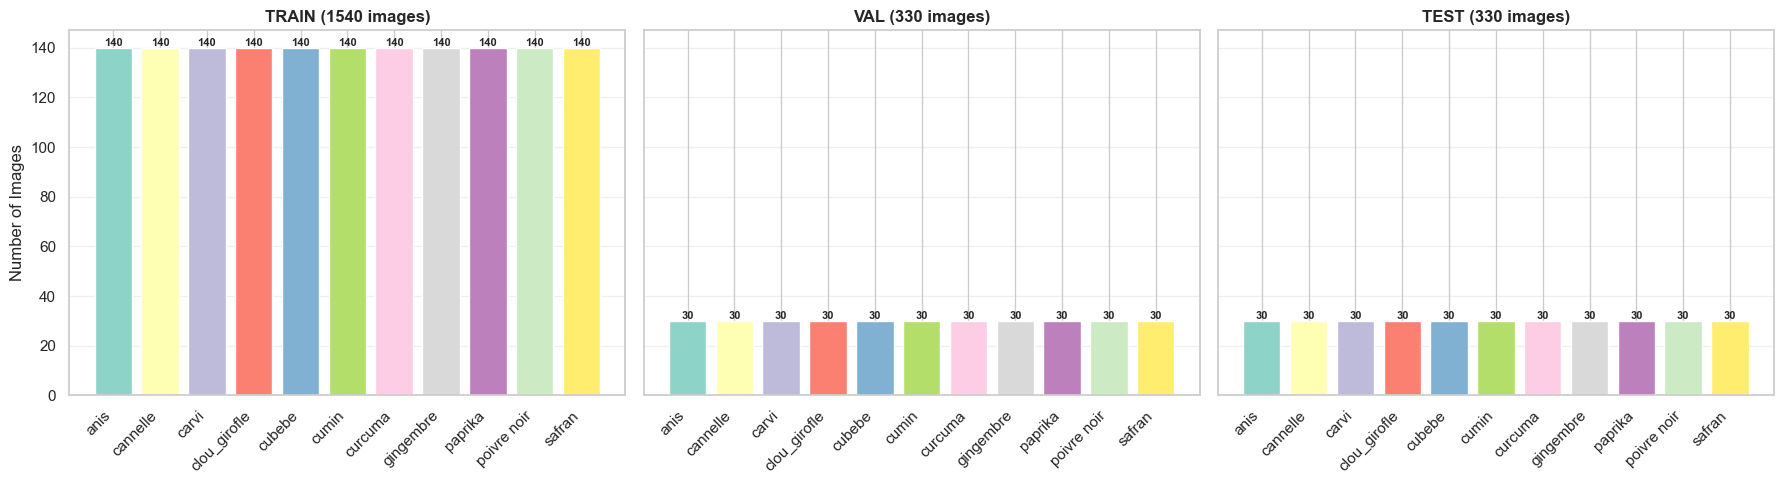

In [25]:
print("\n" + "="*80)
print("🔀 TRAIN/VAL/TEST SPLIT ANALYSIS")
print("="*80)

split_counts = {}
for split in ['train', 'val', 'test']:
    root = SPLITS / split
    if root.exists():
        classes = sorted([d.name for d in root.iterdir() if d.is_dir()])
        counts = {c: len(iter_images(root/c)) for c in classes}
        split_counts[split] = counts
    else:
        print(f"⚠️  {split.upper()} split not found")

if split_counts:
    # Summary table
    splits_df = pd.DataFrame(split_counts).fillna(0).astype(int)
    print("\n📊 Images per Class:")
    display(splits_df)
    
    # Statistics
    print("\n📈 Split Distribution:")
    total = sum(sum(v.values()) for v in split_counts.values())
    for split in ['train', 'val', 'test']:
        if split in split_counts:
            count = sum(split_counts[split].values())
            pct = (count / total * 100) if total > 0 else 0
            print(f"  {split.upper():8} → {count:4d} images ({pct:5.1f}%)")
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    colors = plt.cm.Set3(np.linspace(0, 1, len(splits_df)))
    
    for i, split in enumerate(['train', 'val', 'test']):
        if split in split_counts:
            classes_list = sorted(split_counts[split].keys())
            values = [split_counts[split].get(c, 0) for c in classes_list]
            axes[i].bar(range(len(classes_list)), values, color=colors)
            axes[i].set_title(f'{split.upper()} ({sum(values)} images)', fontweight='bold', fontsize=12)
            axes[i].set_xticks(range(len(classes_list)))
            axes[i].set_xticklabels(classes_list, rotation=45, ha='right')
            axes[i].grid(axis='y', alpha=0.3)
            for j, v in enumerate(values):
                axes[i].text(j, v, str(v), ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    axes[0].set_ylabel('Number of Images')
    plt.tight_layout()
    plt.show()

---
## 3. IMAGE QUALITY ANALYSIS
Resolution, brightness, contrast, and aspect ratio


📏 IMAGE QUALITY ANALYSIS


Analyzing balanced: 100%|██████████| 500/500 [00:03<00:00, 143.71it/s]


✅ Quality Analysis: 1000/1000 images valid

📊 Descriptive Statistics:


width                                                     height  \
          count    mean     std    min    25%    50%    75%     max  count   
dataset                                                                      
balanced  500.0  505.45  346.35  384.0  384.0  384.0  512.0  3000.0  500.0   
merged    500.0  474.37   58.37  384.0  384.0  512.0  512.0   512.0  500.0   

                  ... brightness         contrast                             \
            mean  ...        75%     max    count   mean   std    min    25%   
dataset           ...                                                          
balanced  546.69  ...     156.31  252.67    500.0  53.35  9.92  20.48  46.76   
merged    474.37  ...     152.63  197.34    500.0  50.89  8.75  25.03  44.38   

                               
            50%    75%    max  
dataset                        
balanced  55.03  60.45  75.64  
merged    51.44  58.02  74.20  

[2 rows x 32 columns]

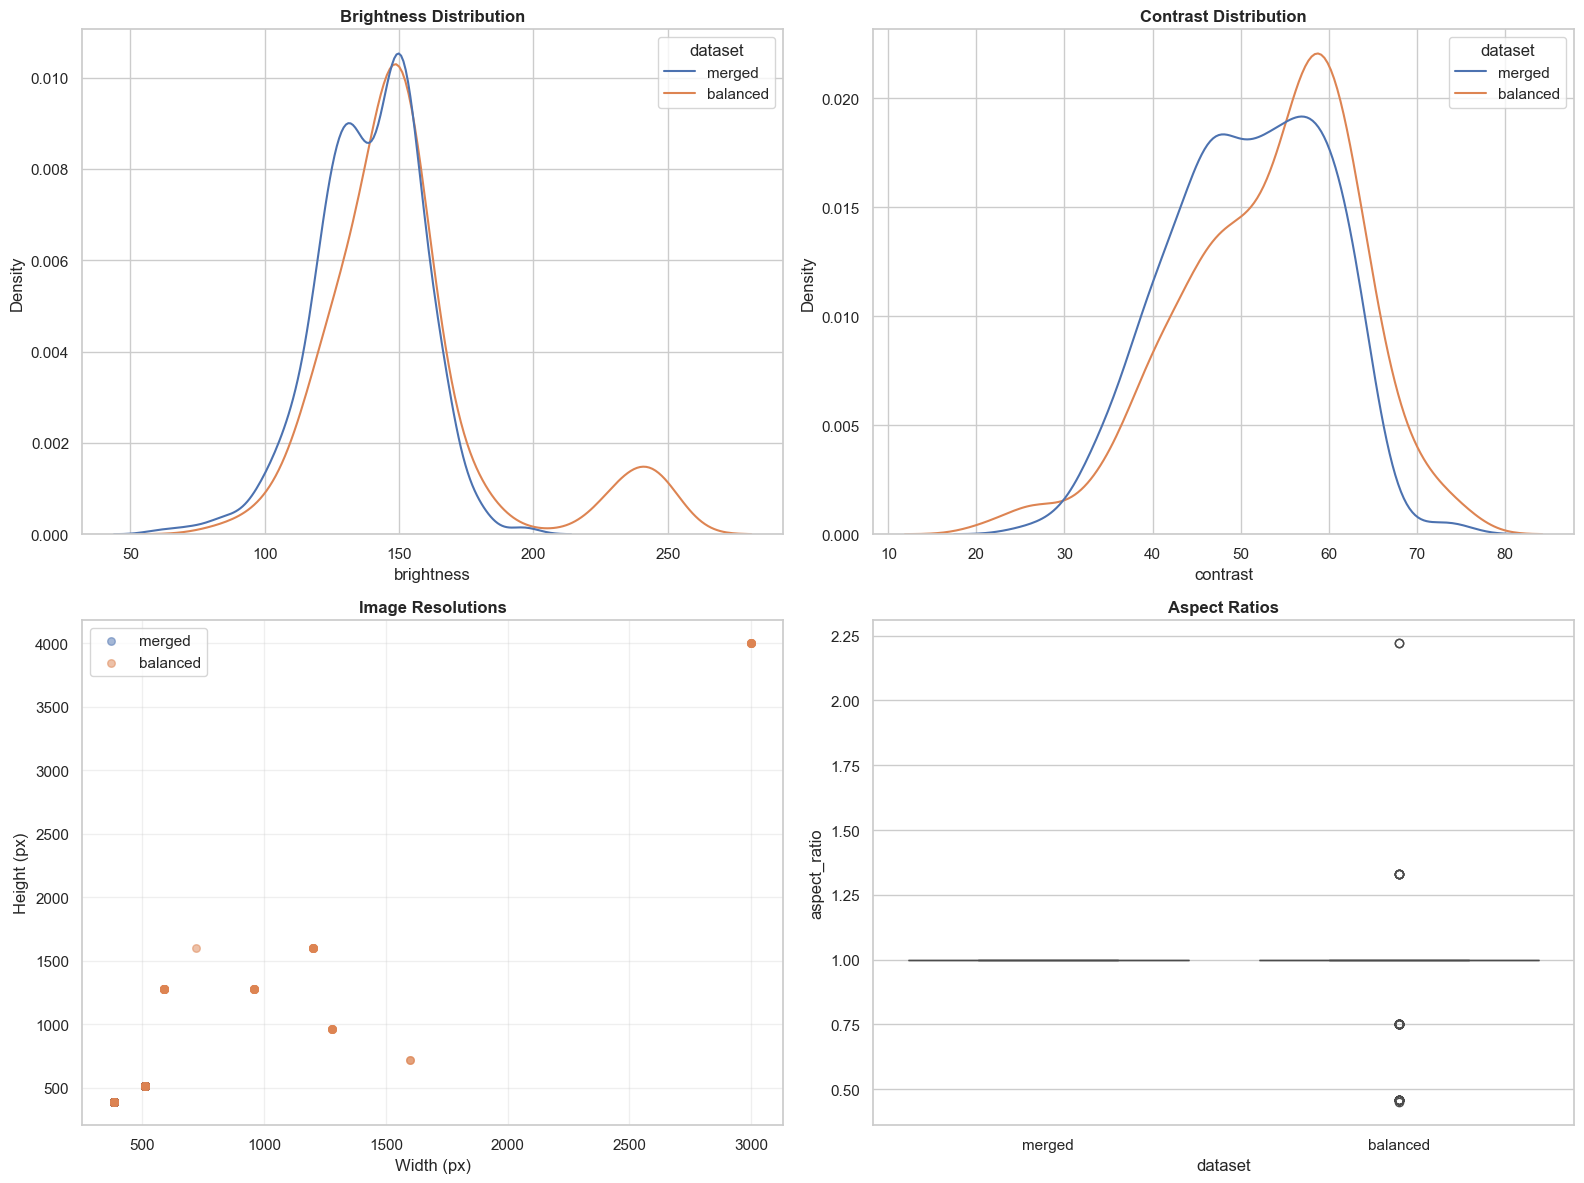

In [34]:
print("\n" + "="*80)
print("📏 IMAGE QUALITY ANALYSIS")
print("="*80)

rows = []
sample_roots = [MERGED, BALANCED]

for root in sample_roots:
    if not root.exists():
        continue
    paths = iter_images(root)[:500]  # Limit to 500 per dataset
    for p in tqdm(paths, desc=f'Analyzing {root.name}'):
        s = img_stats(p)
        s['dataset'] = root.name
        rows.append(s)

df_quality = pd.DataFrame(rows)
df_ok = df_quality[df_quality['ok']]

print(f"\n✅ Quality Analysis: {len(df_ok)}/{len(df_quality)} images valid")
print("\n📊 Descriptive Statistics:")
display(df_ok.groupby('dataset')[['width', 'height', 'brightness', 'contrast']].describe().round(2))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Brightness
sns.kdeplot(data=df_ok, x='brightness', hue='dataset', ax=axes[0, 0])
axes[0, 0].set_title('Brightness Distribution', fontweight='bold')

# Contrast
sns.kdeplot(data=df_ok, x='contrast', hue='dataset', ax=axes[0, 1])
axes[0, 1].set_title('Contrast Distribution', fontweight='bold')

# Resolution
for dataset in df_ok['dataset'].unique():
    subset = df_ok[df_ok['dataset'] == dataset]
    axes[1, 0].scatter(subset['width'], subset['height'], alpha=0.5, label=dataset, s=30)
axes[1, 0].set_title('Image Resolutions', fontweight='bold')
axes[1, 0].set_xlabel('Width (px)')
axes[1, 0].set_ylabel('Height (px)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Aspect Ratio
df_ok_valid = df_ok[df_ok['aspect_ratio'] > 0]
sns.boxplot(data=df_ok_valid, x='dataset', y='aspect_ratio', ax=axes[1, 1])
axes[1, 1].set_title('Aspect Ratios', fontweight='bold')

plt.tight_layout()
plt.show()

---
## 4. DATA INTEGRITY CHECKS
Corrupted files, duplicates, and data leaks

In [27]:
print("\n" + "="*80)
print("🚨 CORRUPTED FILES DETECTION")
print("="*80)

bad = df_quality[~df_quality['ok']]
print(f"\nTotal corrupted: {len(bad)} files")

if len(bad) > 0:
    print("\nBy dataset:")
    for dataset in bad['dataset'].unique():
        count = len(bad[bad['dataset'] == dataset])
        print(f"  {dataset:12} → {count:3d} files")
    
    bad_path = OUT / 'corrupted_images.csv'
    bad.to_csv(bad_path, index=False)
    print(f"\n💾 Saved to: {bad_path}")
else:
    print("✅ No corrupted files detected!")


🚨 CORRUPTED FILES DETECTION

Total corrupted: 0 files
✅ No corrupted files detected!


In [ ]:
print("\n" + "="*80)
print("⚠️  DATA LEAK DETECTION (SHA1 Hash)")
print("="*80)

def map_sha1(root: Path, max_imgs=2000):
    """Build SHA1 hash map for exact duplicate detection."""
    m = {}
    if not root.exists():
        return m
    
    for p in tqdm(iter_images(root)[:max_imgs], desc=f'SHA1 {root.name}', leave=False):
        h = sha1_file(p)
        if h:
            m[h] = p.name
    return m

print("\nComputing SHA1 hashes...")
sha_train = map_sha1(SPLITS/'train')
sha_val = map_sha1(SPLITS/'val')
sha_test = map_sha1(SPLITS/'test')

# Detect leaks
leaks = {
    'train_val': len(sha_train.keys() & sha_val.keys()),
    'train_test': len(sha_train.keys() & sha_test.keys()),
    'val_test': len(sha_val.keys() & sha_test.keys())
}

total_leaks = sum(leaks.values())

print("\n📊 Data Leak Summary:")
print(f"  Train ↔ Val:   {leaks['train_val']:3d} identical files")
print(f"  Train ↔ Test:  {leaks['train_test']:3d} identical files")
print(f"  Val ↔ Test:    {leaks['val_test']:3d} identical files")
print(f"  {'-'*40}")
print(f"  TOTAL LEAKS:   {total_leaks:3d} " + ("❌" if total_leaks > 0 else "✅"))

# Export
leak_report = {'leaks': leaks, 'total': total_leaks, 'status': 'OK' if total_leaks == 0 else 'WARNING'}
with open(OUT/'split_leaks.json', 'w', encoding='utf-8') as f:
    json.dump(leak_report, f, indent=2)


⚠️  DATA LEAK DETECTION (SHA1 Hash)

Computing SHA1 hashes...



📊 Data Leak Summary:
  Train ↔ Val:     5 identical files
  Train ↔ Test:   10 identical files
  Val ↔ Test:      0 identical files
  ----------------------------------------
  TOTAL LEAKS:    15 ❌

💾 Saved to: c:\Users\zaineb\Desktop\spices 2-2\notebooks\eda_outputs\split_leaks.json


---
## 5. VISUAL SAMPLES BY CLASS
Gallery of representative images


🖼️  VISUAL SAMPLES BY CLASS

Showing 11 classes from balanced dataset



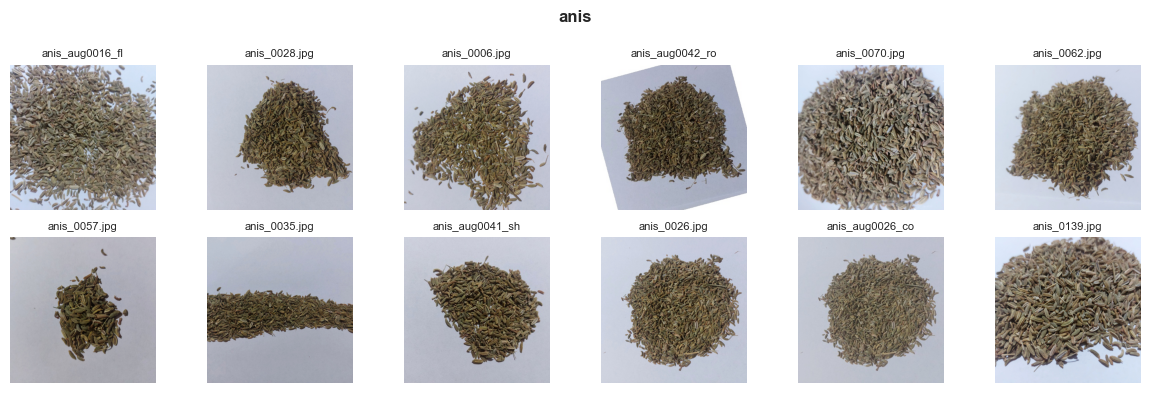

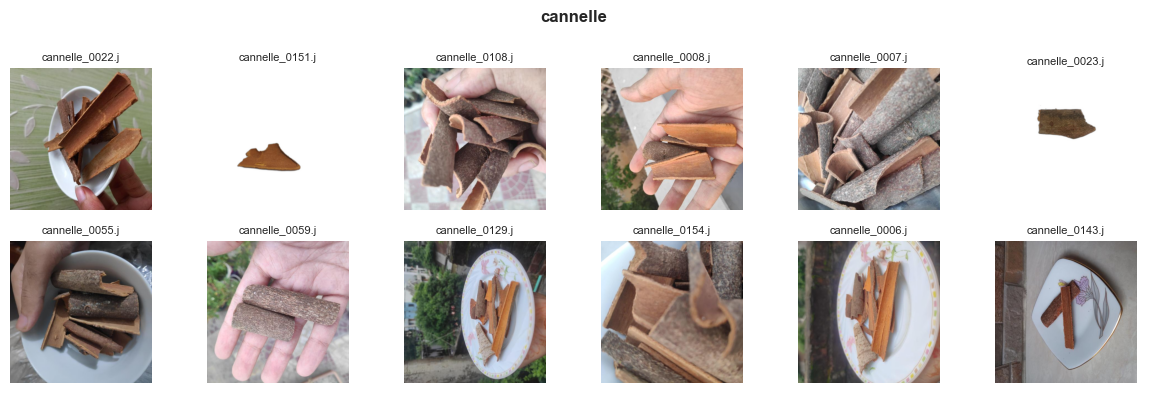

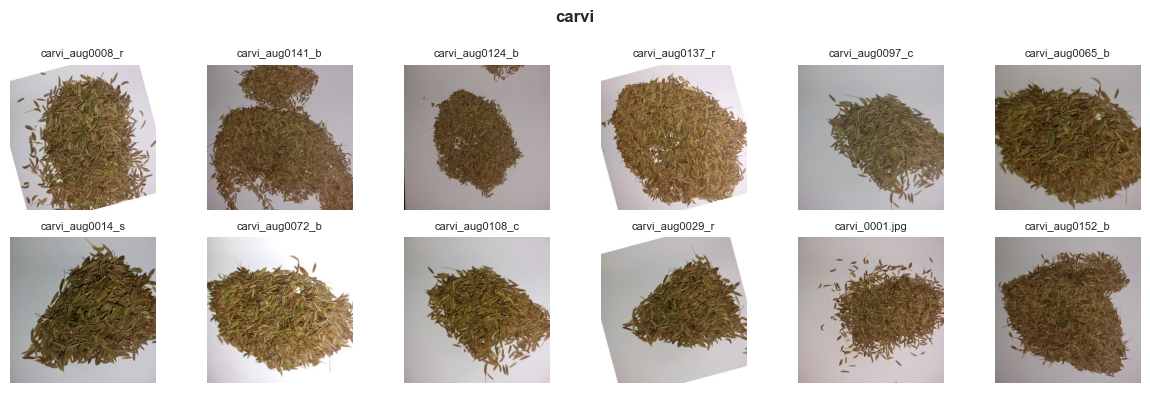

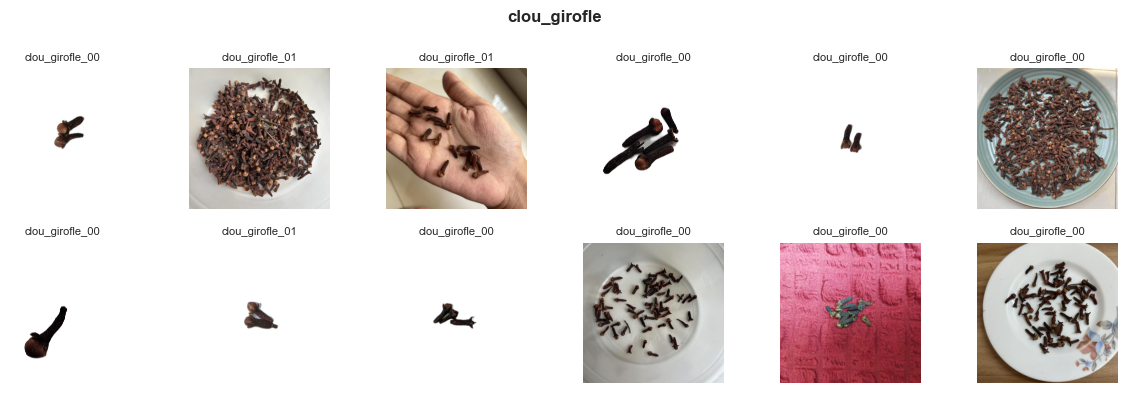

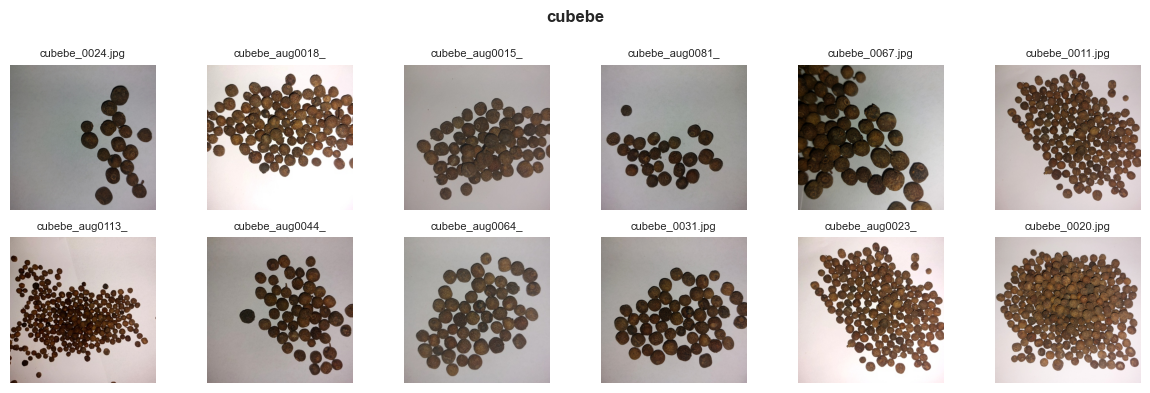

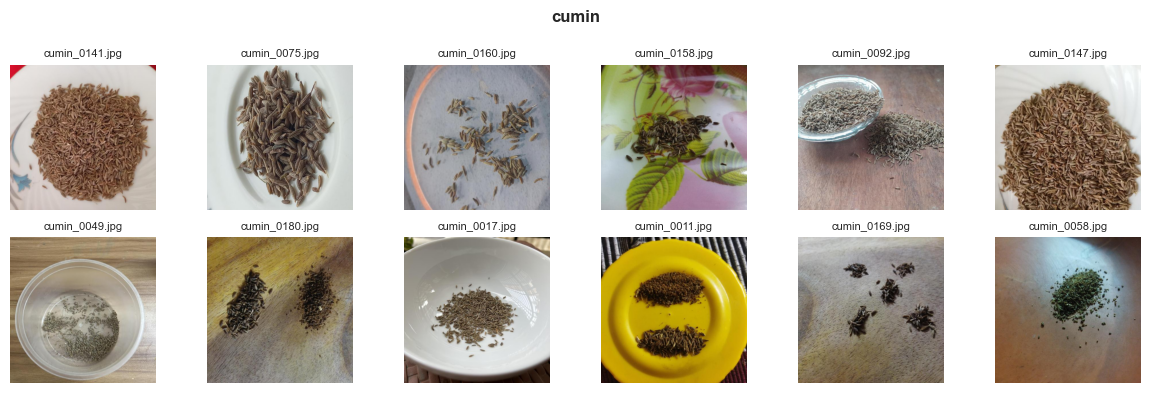

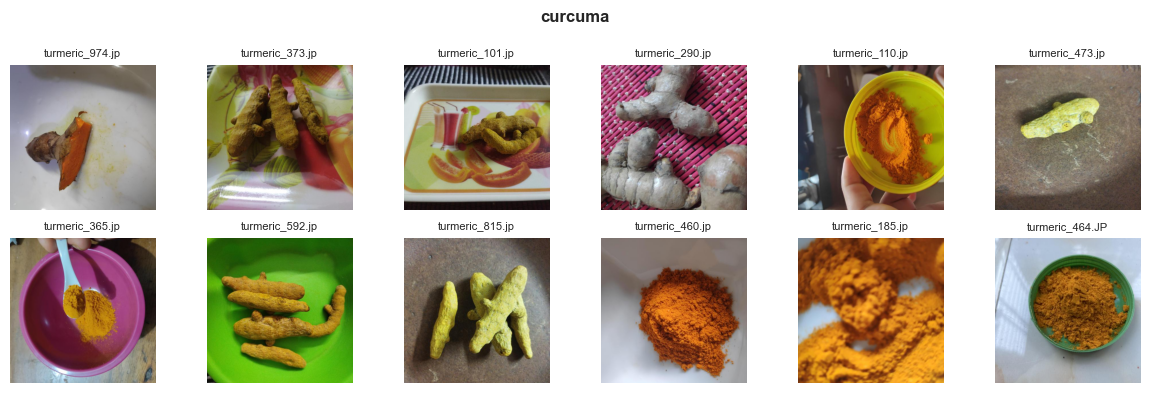

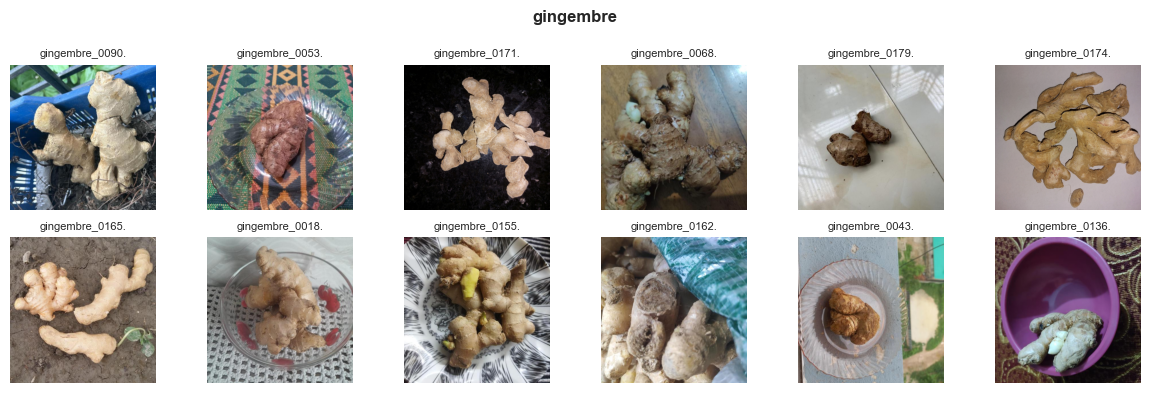

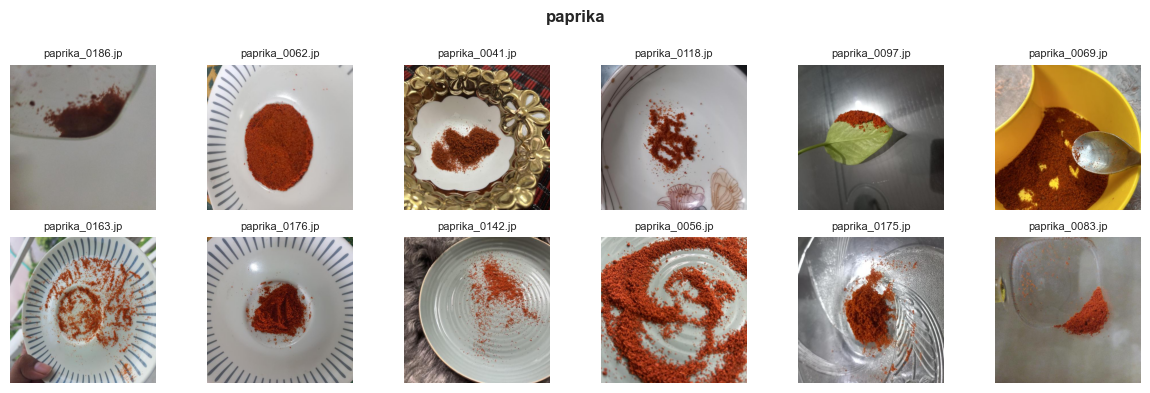

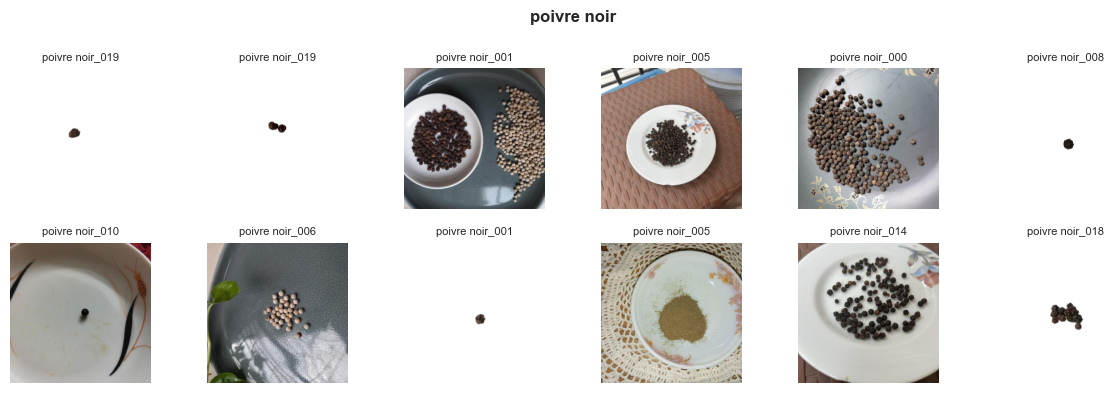

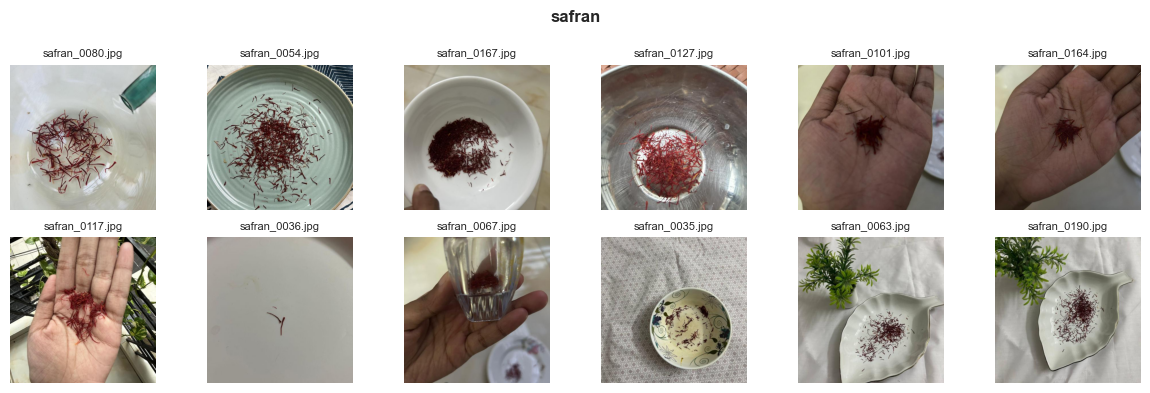

In [30]:
def show_grid(root: Path, cls: str, n=12):
    """Display grid of images from a specific class."""
    paths = iter_images(root/cls)
    if not paths:
        print(f"⚠️  No images found in {cls}")
        return
    
    sel = random.sample(paths, min(n, len(paths)))
    cols = 6
    rows = math.ceil(len(sel) / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = np.array(axes).reshape(rows, cols)
    
    for ax, p in zip(axes.flatten(), sel):
        try:
            im = open_image(p)
            ax.imshow(im)
            ax.set_title(p.name[:15], fontsize=8)
        except:
            ax.text(0.5, 0.5, "Error", ha='center', va='center')
        ax.axis('off')
    
    for ax in axes.flatten()[len(sel):]:
        ax.axis('off')
    
    fig.suptitle(f'{cls}', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("🖼️  VISUAL SAMPLES BY CLASS")
print("="*80)

if BALANCED.exists():
    classes = sorted([d.name for d in BALANCED.iterdir() if d.is_dir()])
    print(f"\nShowing {len(classes)} classes from balanced dataset\n")
    
    for cls in classes:
        show_grid(BALANCED, cls, n=12)
else:
    print("❌ Balanced dataset not found")

---
## 6. COLOR ANALYSIS
Average RGB values per class


🎨 COLOR ANALYSIS

Extracting color samples...


100%|██████████| 11/11 [00:10<00:00,  1.02it/s]


📊 Average RGB by Class:


R      G      B
class                            
anis          147.0  144.0  142.0
cannelle      169.0  153.0  146.0
carvi         160.0  145.0  132.0
clou_girofle  192.0  177.0  174.0
cubebe        149.0  137.0  131.0
cumin         144.0  126.0  113.0
curcuma       133.0  111.0   77.0
gingembre     128.0  130.0  122.0
paprika       148.0  119.0  109.0
poivre noir   205.0  200.0  194.0
safran        152.0  146.0  138.0

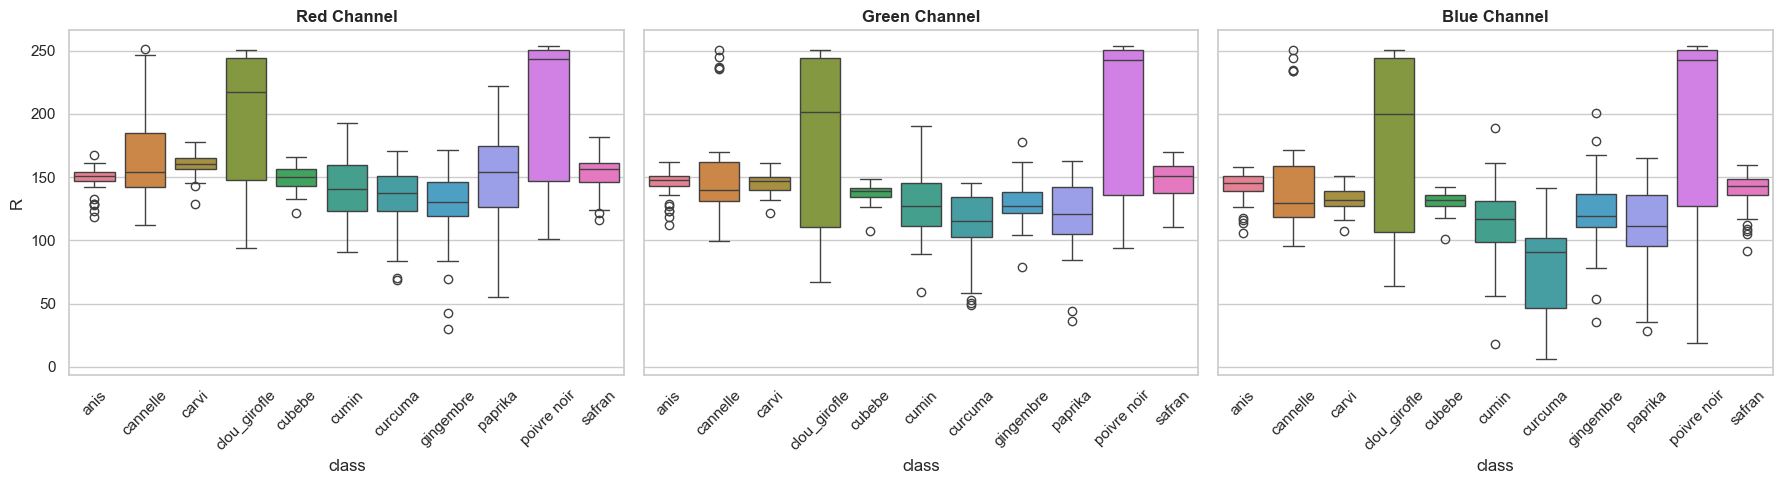

In [31]:
print("\n" + "="*80)
print("🎨 COLOR ANALYSIS")
print("="*80)

# Sample colors
colors_data = []
root = SPLITS/'train' if (SPLITS/'train').exists() else BALANCED

if root.exists():
    classes = sorted([d.name for d in root.iterdir() if d.is_dir()])
    
    print("\nExtracting color samples...")
    for cls in tqdm(classes):
        paths = iter_images(root/cls)[:30]
        for p in paths:
            r, g, b = get_avg_color(p)
            if r is not None:
                colors_data.append({'class': cls, 'R': r, 'G': g, 'B': b})
    
    df_colors = pd.DataFrame(colors_data)
    
    print("\n📊 Average RGB by Class:")
    display(df_colors.groupby('class')[['R', 'G', 'B']].mean().round(0))
    
    # Visualize RGB distributions
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    palette = sns.color_palette("husl", len(classes))
    
    sns.boxplot(data=df_colors, x='class', y='R', ax=axes[0], palette=palette)
    axes[0].set_title('Red Channel', fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    
    sns.boxplot(data=df_colors, x='class', y='G', ax=axes[1], palette=palette)
    axes[1].set_title('Green Channel', fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    
    sns.boxplot(data=df_colors, x='class', y='B', ax=axes[2], palette=palette)
    axes[2].set_title('Blue Channel', fontweight='bold')
    axes[2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("❌ No dataset found")